In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from time import sleep
import pandas as pd
import re
import pickle

# Scraper

In [2]:
address = "http://infobanjir.scadatron.com/mada/smimicT.asp"
driver = webdriver.Chrome(service=Service("../webdriver/chromedriver.exe"))
driver.get(address)
dismissbtn_xp = '//*[@id="cm_map"]/div[2]/table/tr/td[2]/button'
pointinfo_xp = '//*[@id="cm_map"]/div/div/div[2]/div[2]/div/div[4]/div/div/div/div[1]/div/div/div'
pointlist_xp = '//*[@id="cm_sidebarDIV"]/table/tr'
pointname_xp = '//*[@id="cm_sidebarDIV"]/table/tr[1]/td'
dismisbtn = WebDriverWait(driver, 10).until(EC.element_to_be_clickable((By.XPATH,dismissbtn_xp)))
dismisbtn.click()

points = driver.find_elements(By.XPATH,pointlist_xp)
stations = []
for i in range(1,len(points)+1):
    locname = WebDriverWait(driver,10).until(
        EC.element_to_be_clickable((By.XPATH,f'//*[@id="cm_sidebarDIV"]/table/tr[{i}]/td/a')))
    locname.click()
    pointinfo = WebDriverWait(driver,10).until(EC.element_to_be_clickable((By.XPATH,pointinfo_xp)))
    try:
        pat = ".+\D(\d+). (.+)\nLatitude: (.+)/(.+)\nLongtitude: (.+)/(.+)"
        stno, station, latitude, latdms, longitude, longdms = re.match(pat,pointinfo.text).groups()
        stations.append({
            'stno':stno,
            'station':station,
            'latitude':latitude,
            'longitude':longitude,
            'latdms':latdms,
            'longdms':longdms,
            'raw':pointinfo.text})
    except ValueError:
        stations.append({'raw':pointinfo.text})
driver.close()

In [8]:

df = pd.DataFrame(stations)
df['longitude'] = df['longitude'].astype(float)
df['latitude'] = df['latitude'].astype(float)
dfnull = df[df['stno'].isnull()]
dfnull

,stno,station,latitude,longitude,latdms,longdms,raw


# Persist

In [9]:
with open('serialized/df_madatelem.pkl','wb') as file:
    pickle.dump(df,file)

# Reload

In [2]:
with open('serialized/df_madatelem.pkl','rb') as file:
    df = pickle.load(file)

In [3]:
df.to_csv("data/MADATelemetry_locations.csv",index=False)

In [11]:
df

,stno,station,latitude,longitude,latdms,longdms,raw
0,1,Kangar,6.448029,100.1855,6°26’52.90”N,100°11’7.80”E,Station1. Kangar\nLatitude: 6.448029/6°26’52.9...
1,2,Jejawi,6.444362,100.2407,6°26’39.70”N,100°14’26.52”E,Station2. Jejawi\nLatitude: 6.444362/6°26’39.7...
2,3,Arau,6.418805,100.2736,6°25’7.70”N,100°16’24.96”E,Station3. Arau\nLatitude: 6.418805/6°25’7.70”N...
3,4,Seriap,6.397000,100.1855,6°23’49.20”N,100°11’7.80”E,Station4. Seriap\nLatitude: 6.397/6°23’49.20”N...
4,5,Kuala Perlis,6.397388,100.1345,6°23’50.60”N,100°8’4.20”E,Station5. Kuala Perlis\nLatitude: 6.397388/6°2...
...,...,...,...,...,...,...,...
138,144,Kg.Whatt Lampam Sg.Lampam,6.107639,100.6131,6°6’27.50”N,100°36’47.16”E,Station144. Kg.Whatt Lampam Sg.Lampam\nLatitud...
139,145,Kg.Titi Serong Yan Kechil,5.827778,100.3887,5°49’40.00”N,100°23’19.32”E,Station145. Kg.Titi Serong Yan Kechil\nLatitud...
140,146,Kg./Sg.Bakong,5.808888,100.3681,5°48’32.00”N,100°22’5.16”E,Station146. Kg./Sg.Bakong\nLatitude: 5.808888/...
141,147,Sg.Pdg.Terap Kg.Kuala Pai,6.251028,100.5221,6°15’3.70”N,100°31’19.56”E,Station147. Sg.Pdg.Terap Kg.Kuala Pai\nLatitud...


# Visual QC

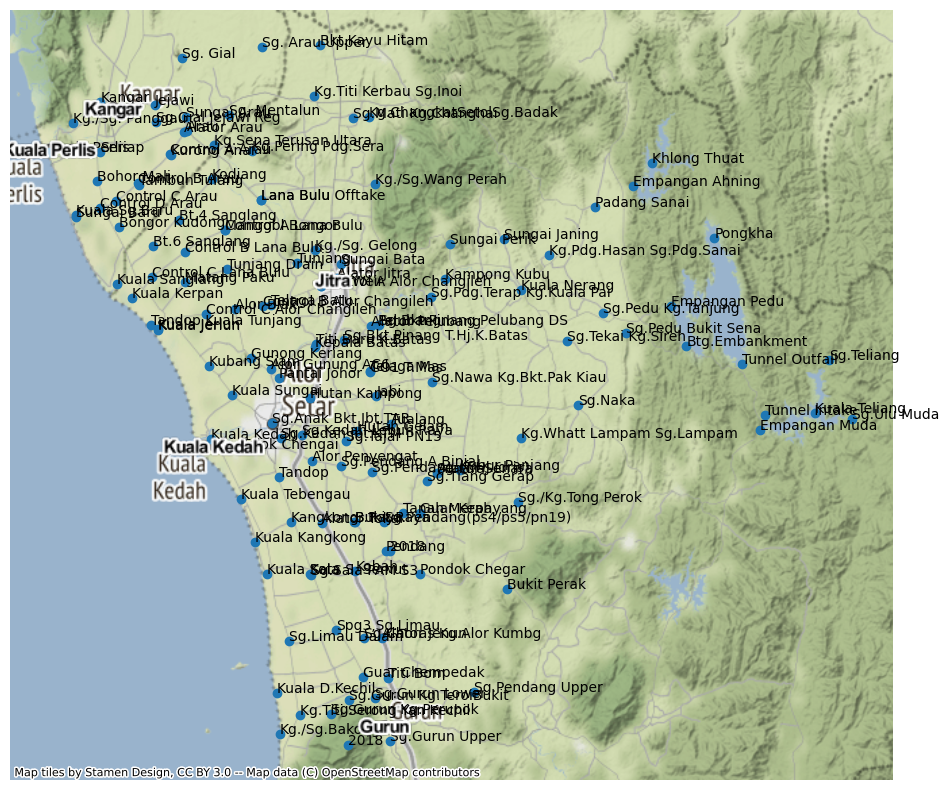

In [13]:
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.pyplot as plt
import contextily as cx

geometry = [Point(xy) for xy in zip(df.longitude,df.latitude)]
gdf = GeoDataFrame(df,crs="EPSG:4326",geometry=geometry)
gdf = gdf.to_crs(epsg=3857)
gdf['coords'] = gdf['geometry'].apply(lambda x: x.representative_point().coords[:])
ax = gdf.plot(figsize=(20,10))
cx.add_basemap(ax)
cx.add_basemap(ax, source=cx.providers.Stamen.TonerLabels)
ax.set_axis_off()
for idx, row in gdf.iterrows():
    plt.annotate(text=row['station'],xy=row['coords'][0])
